In [2]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
month = 'July'
filenumbers = ! ls ~/Dropbox/zorrodata/$month\HRstars/
fileNumbers = list(set([f.strip('S20').split('.')[0][:-1] + '\n' for f in filenumbers]))
myfile = open(f'./Zorro{month}HRStars.txt', 'w')
myfile.writelines(fileNumbers)
myfile.close()

In [4]:
! python extractPSFParameters.py --dataDir='/Users/clairealice/Dropbox/zorrodata/MayHRstars/' --fileNumbers='Code/ZorroMayHRStars.txt' --savePath='Fits/{}/filter{}/{}_{}psfs.p' --fileNameFormat='S20{}{}.fits.bz2'


### load and plot example

In [52]:
number = '190716Z0672'
hdu = fits.open('/Users/clairealice/Dropbox/zorrodata/JulyHRstars/'+f'S20{number}b.fits.bz2')
dataB = hdu[0].data
headerB = hdu[0].header
hdu.close()
hdu = fits.open('/Users/clairealice/Dropbox/zorrodata/JulyHRstars/'+f'S20{number}r.fits.bz2')
dataR = hdu[0].data
headerR = hdu[0].header
hdu.close()

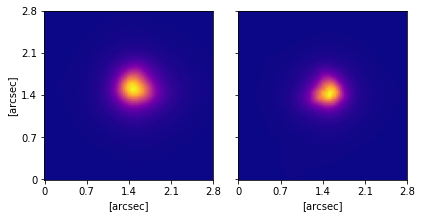

In [53]:
expTime=[0,1000]
plt.figure(figsize=(6,3))
ax=plt.subplot(121)
plt.imshow(dataB[expTime[0]:expTime[1]].mean(axis=0), origin='lower', cmap='plasma')
plt.xticks([0, 64, 128, 192, 256], [0, .7, 1.4, 2.1, 2.8])
plt.yticks([0, 64, 128, 192, 256], [0, .7, 1.4, 2.1, 2.8])
plt.ylabel('[arcsec]')
plt.xlabel('[arcsec]')
# ax.text(5, 235, '692nm', color='gold', fontsize=12)
ax=plt.subplot(122)
plt.imshow(dataR[expTime[0]:expTime[1]].mean(axis=0), origin='lower', cmap='plasma')
plt.xticks([0, 64, 128, 192, 256], [0, .7, 1.4, 2.1, 2.8])
plt.yticks([0, 64, 128, 192, 256], [])
# ax.text(5, 235, '880nm', color='gold', fontsize=12)
plt.xlabel('[arcsec]')

plt.tight_layout()

# Analyze outputs!

In [37]:
from analyzePSFParameters import psfParameters

zorrop = psfParameters(source='Zorro', fileNumbers='Code/ZorroJulyHRStars.txt', baseDir='../', filters=(562,832))

## save header info into dict

In [46]:
def readHeaders(headerDict, filenames):
    for fn in filenames:
        month = 'July' if fn[2:4]=='07' else 'June' if fn[2:4]=='06' else 'May' if fn[2:4]=='05'
        dataDir = f'/Users/clairealice/Dropbox/zorrodata/{month}HRstars/'

        try:
            try:
                hdu = fits.open(dataDir + 'S20' + fn + 'b.fits.bz2')
                header = hdu[0].header
                hdu.close()
            except IOError:
                print(fn)
                continue
        except FileNotFoundError:
            try:
                hdu = fits.open(dataDir + 'S20' + fn + 'r.fits.bz2')
                header = hdu[0].header
                hdu.close()
            except IOError:
                print(fn)
                continue
                
        try:
            headerDict[fn] = {k: header[k] for k in ['TARGRA', 'TARGDEC', 
                                                 'AIRMASS', 'DATE-OBS', 
                                                 'OBSTIME', 'HUMIDITY',
                                                 'FOCUS']}
            try:
                headerDict[fn]['object'] = header['COMMENT'][2]
            except IndexError:
                headerDict[fn]['object'] = header['OBJECT']
        except KeyError:
            print(f'one of the keys missing in file {fn}')

    return headerDict

headerdict = {}
headers = readHeaders(headerdict, zorrop.fileNumbers)

with open('./ZorroJulyHeaders.p','wb') as file:
    pickle.dump(headers, file)

one of the keys missing in file 190716Z0672


## filter data function

In [56]:
import analysisHelper as helper

#load in fileNames
fileNames = []
for month in ['May', 'June', 'July']:  
    fnfile = f'./Zorro{month}HRStars.txt'
    fileNames += list(np.genfromtxt(fnfile, dtype='str', delimiter='\n'))

acceptedFiles = helper.filterData(fileNames, './ZorroHRHeaders_05ThruMid07.p', 
                           '../Fits/ZorroHRCentroids_05ThruMid07.p', fwhmWeight=0.5)
len(acceptedFiles)

132

# selection plot

In [57]:
# load in dict of centroids
with open('../Fits/ZorroHRCentroids_05ThruMid07.p', 'rb') as file:
    centroidDict = pickle.load(file)

#load in fileNames
fileNames = []
for month in ['May', 'June', 'July']:  
    fnfile = f'./Zorro{month}HRStars.txt'
    fileNames += list(np.genfromtxt(fnfile, dtype='str', delimiter='\n'))

files_fullfwhm = helper.filterData(fileNames, './ZorroHRHeaders_05ThruMid07.p', 
                                   '../Fits/ZorroHRCentroids_05ThruMid07.p', fwhmWeight=1)
fullfwhm = psfParameters(source='Zorro', fileNumbers='Code/ZorroJulyHRStars.txt', baseDir='../', filters=(562,832))
fullfwhm.fileNumbers = files_fullfwhm
fullfwhm.loadAllParameters()
comR_full = np.array([np.sqrt((centroidDict[562][fn]['x']-128)**2+
                              (centroidDict[562][fn]['y']-128)**2) for fn in files_fullfwhm]).mean(axis=1)

files_halffwhm = helper.filterData(fileNames, './ZorroHRHeaders_05ThruMid07.p', 
                                   '../Fits/ZorroHRCentroids_05ThruMid07.p', fwhmWeight=0.5)
halffwhm = psfParameters(source='Zorro', fileNumbers='Code/ZorroJulyHRStars.txt', baseDir='../', filters=(562,832))
halffwhm.fileNumbers = files_halffwhm
halffwhm.loadAllParameters()
comR_half = np.array([np.sqrt((centroidDict[562][fn]['x']-128)**2+
                              (centroidDict[562][fn]['y']-128)**2) for fn in files_halffwhm]).mean(axis=1)

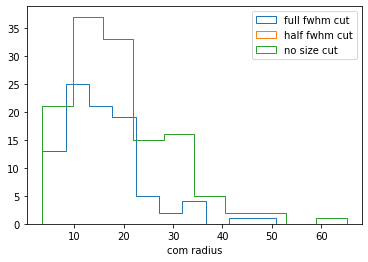

In [58]:
plt.hist(comR_full, histtype='step', label='full fwhm cut');
plt.hist(comR_half, histtype='step', label='half fwhm cut');
plt.legend()
plt.xlabel('com radius');

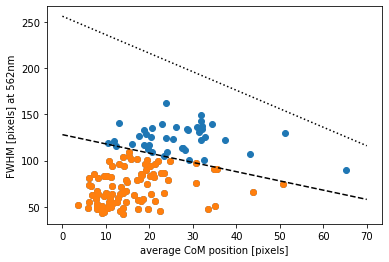

In [62]:
plt.plot(comR_half, halffwhm.parameters['15'][562]['size'][:,-1]/halffwhm.scale[halffwhm.filters[0]],'o')
plt.plot(comR_full, fullfwhm.parameters['15'][562]['size'][:,-1]/halffwhm.scale[halffwhm.filters[0]],'o')

plt.plot(np.linspace(0,70,10), 128*np.ones(10) - np.linspace(0,70,10), 'k--')
plt.plot(np.linspace(0,70,10), 2*(128*np.ones(10) - np.linspace(0,70,10)), 'k:')

plt.ylabel('FWHM [pixels] at 562nm')
plt.xlabel('average CoM position [pixels]');